**Innovating for land restoration in the sahel**

In [ ]:

import ee
import geemap
import folium
import ipywidgets as widgets


ee.Initialize(project='buoyant-site-454305-j8')


modis = ee.ImageCollection("MODIS/061/MCD12Q1").select('LC_Type1')

Precipitation Map

In [254]:

chirps = ee.ImageCollection("UCSB-CHG/CHIRPS/PENTAD").select("precipitation")


africa_roi = ee.Geometry.Polygon([
    [-20, 40], [55, 40], [55, -40], [-20, -40], [-20, 40]  # Coordenadas de África
])


years = list(range(2003, 2024))  # 2003 a 2023
chirps_dict = {}

for year in years:

    annual_precip = chirps.filter(ee.Filter.calendarRange(year, year, 'year')).sum()
    chirps_dict[year] = annual_precip.clip(africa_roi)


Map = geemap.Map(center=[10, 20], zoom=3)

# Definir parámetros de visualización (mm de precipitación)
vis_params = {
    "min": 0, "max": 2000,  # Valores típicos de precipitación anual en mm
    "palette": ["#ffffff", "#b3ccff", "#6699ff", "#3366ff", "#0033ff",
                "#009933", "#33cc33", "#ffff00", "#ff9900", "#ff3300", "#990000"]
}

# Agregar la leyenda para precipitación CHIRPS
legend_labels = [
    "0 mm (Sin lluvia)",
    "50 mm",
    "100 mm",
    "250 mm",
    "500 mm",
    "750 mm",
    "1000 mm",
    "1250 mm",
    "1500 mm",
    "1750 mm",
    "2000 mm (Máxima precipitación)"
]

legend_colors = [
    "#ffffff", "#b3ccff", "#6699ff", "#3366ff", "#0033ff",
    "#009933", "#33cc33", "#ffff00", "#ff9900", "#ff3300", "#990000"
]

Map.add_legend(title="Precipitación Anual (mm)", labels=legend_labels, colors=legend_colors)

# Crear un control deslizante para seleccionar el año
slider = widgets.IntSlider(min=2003, max=2023, step=1, value=2023, description="Año:")

# Función para actualizar el mapa cuando cambia el slider
def update_map(year):
    Map.layers = []  # Limpiar capas anteriores (NO la leyenda)
    img = chirps_dict[year]  # Obtener la imagen del año seleccionado
    Map.addLayer(img, vis_params, f"Precipitación {year}")

# Conectar el slider con la función
widgets.interactive(update_map, year=slider)

# Mostrar el mapa y el slider
display(slider)
Map

IntSlider(value=2023, description='Año:', max=2023, min=2003)

Map(center=[10, 20], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(chil…

In [ ]:

pop_data = ee.Image("WorldPop/GP/100m/pop_age_sex_cons_unadj/NGA_2020")

Population Sahel Map

In [255]:
# Lista de países del Sahel según WorldPop
sahel_countries = ["MRT", "SEN", "MLI", "BFA", "NER", "TCD", "SDN", "SSD", "ERI"]

# Crear una lista de imágenes de población para cada país y seleccionar la banda correcta
pop_images = []
for code in sahel_countries:
    try:
        pop_image = ee.Image(f"WorldPop/GP/100m/pop_age_sex_cons_unadj/{code}_2020").select("population")
        pop_images.append(pop_image)
    except Exception as e:
        print(f"Datos no disponibles para {code}: {e}")

# Fusionar todas las imágenes en una sola
pop_collection = ee.ImageCollection(pop_images).mosaic()

# Definir la región del Sahel (aproximadamente)
region = ee.Geometry.BBox(-18, 5, 30, 20)  # (lon_min, lat_min, lon_max, lat_max)

# Configurar mapa interactivo
Map = geemap.Map()
Map.centerObject(region, 4)
Map.addLayer(pop_collection.clip(region),
             {"min": 0, "max": 500, "palette": ["blue", "yellow", "red"]},
             "Población Sahel 2020")

# Mostrar el mapa
Map

Map(center=[12.78625134285786, 5.999999999999911], controls=(WidgetControl(options=['position', 'transparent_b…

Regions Administrations in Sahel

In [256]:

admin_boundaries = ee.FeatureCollection("FAO/GAUL/2015/level0")


sahel_countries = ["Mauritania", "Senegal", "Mali", "Burkina Faso", "Niger", "Chad", "Sudan", "South Sudan", "Eritrea"]

# Filtrar solo los países del Sahel
sahel_boundaries = admin_boundaries.filter(ee.Filter.inList("ADM0_NAME", sahel_countries))

# Configurar mapa interactivo
Map = geemap.Map()
Map.centerObject(sahel_boundaries, 4)
Map.addLayer(sahel_boundaries, {"color": "black"}, "Fronteras del Sahel")

# Mostrar el mapa interactivo
Map

Map(center=[16.584265126758684, 12.349587287037156], controls=(WidgetControl(options=['position', 'transparent…

Mix for maps (Population, deforestation and precipitation)

In [257]:

sahel_region = ee.Geometry.BBox(-18, 5, 30, 20)  # Aproximadamente lon_min, lat_min, lon_max, lat_max

admin_boundaries = ee.FeatureCollection("FAO/GAUL/2015/level0")
sahel_countries = ["Mauritania", "Senegal", "Mali", "Burkina Faso", "Niger", "Chad", "Sudan", "South Sudan", "Eritrea"]
sahel_boundaries = admin_boundaries.filter(ee.Filter.inList("ADM0_NAME", sahel_countries))

sahel_countries_codes = ["MRT", "SEN", "MLI", "BFA", "NER", "TCD", "SDN", "SSD", "ERI"]
pop_images = []
for code in sahel_countries_codes:
    try:
        pop_image = ee.Image(f"WorldPop/GP/100m/pop_age_sex_cons_unadj/{code}_2020").select("population")
        pop_images.append(pop_image)
    except Exception as e:
        print(f"Datos no disponibles para {code}: {e}")

pop_collection = ee.ImageCollection(pop_images).mosaic().clip(sahel_region)
pop_collection = pop_collection.reproject(crs="EPSG:4326", scale=1000)  # Reducir resolución


modis_landcover = ee.ImageCollection("MODIS/006/MCD12Q1").filter(ee.Filter.calendarRange(2020, 2020, "year")).first().clip(sahel_region)


chirps = ee.ImageCollection("UCSB-CHG/CHIRPS/PENTAD").filterDate("2000-01-01", "2020-12-31")
chirps_mean = chirps.mean().select("precipitation")  # Seleccionar la banda correcta
chirps_mean = chirps_mean.clip(sahel_region).reproject(crs="EPSG:4326", scale=10000)  # Reducir resolución

# 🔹 Crear mapa interactivo con África visible pero datos limitados al Sahel
Map = geemap.Map()
Map.centerObject(ee.Geometry.BBox(-25, -35, 55, 40), 3)  # Centrar en África

# Agregar capas optimizadas
Map.addLayer(admin_boundaries, {"color": "gray"}, "Fronteras de África")  # Mostrar todo África en gris
Map.addLayer(sahel_boundaries, {"color": "black"}, "Fronteras del Sahel")  # Solo Sahel en negro
Map.addLayer(pop_collection, {"min": 0, "max": 500, "palette": ["blue", "yellow", "red"]}, "Población Sahel 2020")
Map.addLayer(modis_landcover, {"bands": ["LC_Type1"], "min": 1, "max": 17, "palette": ["green", "brown", "blue"]}, "MODIS Land Cover 2020")
Map.addLayer(chirps_mean, {"min": 0, "max": 1000, "palette": ["white", "blue", "purple"]}, "Precipitación CHIRPS 2000-2020")

# Mostrar el mapa interactivo
Map

Map(center=[2.305331800163843, 14.999999999999785], controls=(WidgetControl(options=['position', 'transparent_…

**Modis global visualization **

In [ ]:

modis = ee.ImageCollection("MODIS/061/MCD12Q1").select("LC_Type1").filterDate("2020-01-01", "2020-12-31").first()
chirps = ee.ImageCollection("UCSB-CHG/CHIRPS/PENTAD").filterDate("2020-01-01", "2020-12-31").mean()

modis_vis = {'min': 1, 'max': 17, 'palette': ["green", "brown", "blue"]}
chirps_vis = {'min': 0, 'max': 2000, 'palette': ["white", "blue", "purple"]}

Map = geemap.Map()
Map.addLayer(modis, modis_vis, "MODIS Land Cover")
Map.addLayer(chirps, chirps_vis, "Precipitación CHIRPS")
Map


Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

Relation for deforestation and precipitation

In [248]:
import ee
import geemap

ee.Initialize(project='buoyant-site-454305-j8')
sahel_roi = ee.Geometry.Polygon([
    [-18, 5], [30, 5], [30, 20], [-18, 20], [-18, 5]
])

modis = ee.ImageCollection("MODIS/061/MCD12Q1").select("LC_Type1") \
    .filterDate("2020-01-01", "2020-12-31").first() \
    .clip(sahel_roi) \
    .reproject(crs="EPSG:4326", scale=500)

# CHIRPS Precipitación (media anual y reproyectado)
chirps = ee.ImageCollection("UCSB-CHG/CHIRPS/PENTAD") \
    .filterDate("2020-01-01", "2020-12-31") \
    .mean() \
    .clip(sahel_roi) \
    .reproject(crs="EPSG:4326", scale=5000)

stats = chirps.reduceRegion(
    reducer=ee.Reducer.percentile([1, 99]),
    geometry=sahel_roi,
    scale=5000,
    bestEffort=True
)

min_precip = stats.getNumber('precipitation_p1').getInfo()
max_precip = stats.getNumber('precipitation_p99').getInfo()

print(f"Rango de precipitación ajustado: {min_precip} mm - {max_precip} mm")

modis_vis = {'min': 1, 'max': 17, 'palette': [
    "#05450a", "#086a10", "#54a708", "#78d203", "#009900",
    "#c6b044", "#dcd159", "#dade48", "#fbff13", "#b6ff05",
    "#27ff87", "#c24f44", "#a5a5a5", "#ff6d4c", "#69fff8",
    "#f9ffa4", "#1c0dff"
]}
chirps_vis = {'min': min_precip, 'max': max_precip, 'palette': ["white", "blue", "purple"]}

Map = geemap.Map(center=[12, 5], zoom=5)
Map.addLayer(modis, modis_vis, "MODIS Land Cover 2020")
Map.addLayer(chirps, chirps_vis, "Precipitación CHIRPS 2020", opacity=0.6)
Map

chirps_layer = Map.addLayer(get_chirps_by_year(2020), chirps_vis_default, "Precipitación CHIRPS", opacity=0.6)
def update_map(year):
    chirps = get_chirps_by_year(year)
    chirps_layer.ee_object = chirps
    chirps_layer.name = f"Precipitación CHIRPS {year}"

year_slider = widgets.IntSlider(min=2010, max=2020, step=1, value=2020, description='Año:')
interactive_slider = widgets.interactive(update_map, year=year_slider)

display(year_slider)
Map


Rango de precipitación ajustado: 0.14773292927563753 mm - 35.8713114237783 mm


IntSlider(value=2020, description='Año:', max=2020, min=2010)

Map(center=[12, 5], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(child…

# **Access to food**

In [278]:
import ee
import geemap
import ipywidgets as widgets
from ipyleaflet import WidgetControl
from IPython.display import display

ee.Initialize(project='buoyant-site-454305-j8')
sahel_roi = ee.Geometry.BBox(-18, 5, 30, 20)

def get_chirps_by_year(year):
    chirps = ee.ImageCollection("UCSB-CHG/CHIRPS/PENTAD") \
        .filterDate(f"{year}-01-01", f"{year}-12-31") \
        .mean() \
        .clip(sahel_roi) \
        .reproject(crs="EPSG:4326", scale=5000)
    return chirps.updateMask(chirps.gt(0))

# livestock  by year
def get_modis_by_year(year):
    return ee.ImageCollection("MODIS/006/MCD12Q1").select("LC_Type1") \
        .filterDate(f"{year}-01-01", f"{year}-12-31") \
        .first() \
        .clip(sahel_roi) \
        .reproject(crs="EPSG:4326", scale=500)

gfsad = ee.Image("USGS/GFSAD1000_V1").clip(sahel_roi)
gfsad_vis = {'min': 0, 'max': 1, 'palette': ['ffffff', '00ff00']}

modis_vis = {
    'min': 1, 'max': 17, 'palette': [
        "#05450a", "#086a10", "#54a708", "#78d203", "#009900",
        "#c6b044", "#dcd159", "#dade48", "#fbff13", "#b6ff05",
        "#27ff87", "#c24f44", "#a5a5a5", "#ff6d4c", "#69fff8",
        "#f9ffa4", "#1c0dff"]
}

chirps_2001 = get_chirps_by_year(2001)
stats = chirps_2001.reduceRegion(
    reducer=ee.Reducer.percentile([1, 99]),
    geometry=sahel_roi,
    scale=5000,
    bestEffort=True
)
min_precip = stats.getNumber('precipitation_p1').getInfo()
max_precip = stats.getNumber('precipitation_p99').getInfo()

chirps_vis = {'min': min_precip, 'max': max_precip, 'palette': ["white", "blue", "purple"]}

Map = geemap.Map(center=[12, 5], zoom=5)
default_year = 2001

Map.addLayer(get_modis_by_year(default_year), modis_vis, f"Oxford livestock  {default_year}")
Map.addLayer(get_chirps_by_year(default_year), chirps_vis, f"Precipitación CHIRPS {default_year}", opacity=0.5)
Map.addLayer(gfsad, gfsad_vis, "Áreas de cultivo GFSAD (2010)", opacity=0.5)


def update_map(year):
    Map.layers = Map.layers[:1]  # Keep only the base map
    Map.addLayer(get_modis_by_year(year), modis_vis, f"Oxford livestock  {year}")
    Map.addLayer(get_chirps_by_year(year), chirps_vis, f"Precipitación CHIRPS {year}", opacity=0.5)
    Map.addLayer(gfsad, gfsad_vis, "Áreas de cultivo GFSAD (2010)", opacity=0.5)

# Year slider
year_slider = widgets.IntSlider(
    min=2001,
    max=2020,
    step=1,
    value=default_year,
    description="Año:",
    layout=widgets.Layout(width='98vw', height='50px'),
    continuous_update=False
)

Map.add_control(WidgetControl(widget=year_slider, position='bottomright'))

widgets.interactive(update_map, year=year_slider)

display(Map)
output_html = "sahel_precipitation_landcover.html"
Map.to_html(output_html)
print(f" Interactive map exported successfully: {output_html}")


Map(center=[12, 5], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(child…

 Interactive map exported successfully: sahel_precipitation_landcover.html


In [ ]:
import ee
import geemap
import plotly.graph_objects as go
from IPython.display import display
#virginia

ee.Initialize(project='buoyant-site-454305-j8')

sahel_roi = ee.Geometry.BBox(-18, 5, 30, 20)


def get_chirps_by_year(year):
    chirps = ee.ImageCollection("UCSB-CHG/CHIRPS/PENTAD") \
        .filterDate(f"{year}-01-01", f"{year}-12-31") \
        .mean() \
        .clip(sahel_roi) \
        .reproject(crs="EPSG:4326", scale=5000)
    return chirps.updateMask(chirps.gt(0))

def get_modis_by_year(year):
    return ee.ImageCollection("MODIS/061/MCD12Q1").select("LC_Type1") \
        .filterDate(f"{year}-01-01", f"{year}-12-31") \
        .first() \
        .clip(sahel_roi) \
        .reproject(crs="EPSG:4326", scale=500)

modis_vis = {
    'min': 1, 'max': 17, 'palette': [
        "#05450a", "#086a10", "#54a708", "#78d203", "#009900",
        "#c6b044", "#dcd159", "#dade48", "#fbff13", "#b6ff05",
        "#27ff87", "#c24f44", "#a5a5a5", "#ff6d4c", "#69fff8",
        "#f9ffa4", "#1c0dff"]
}
chirps_vis = {'min': min_precip, 'max': max_precip, 'palette': ["white", "blue", "purple"]}

Map = geemap.Map(center=[12, 5], zoom=5)

default_year = 2001
Map.addLayer(get_modis_by_year(default_year), modis_vis, f"MODIS Land Cover {default_year}")
Map.addLayer(get_chirps_by_year(default_year), chirps_vis, f"Precipitación CHIRPS {default_year}", opacity=0.5)

years = list(range(2001, 2021))
precipitation = [get_chirps_by_year(year).reduceRegion(
    reducer=ee.Reducer.mean(),
    geometry=sahel_roi,
    scale=5000,
    bestEffort=True).getInfo()['precipitation'] for year in years]

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=years,
    y=precipitation,
    mode='lines+markers',
    name='Precipitación CHIRPS'
))

# Slider para cambiar el año
fig.update_layout(
    title='Precipitación CHIRPS en el Sahel (2001-2020)',
    xaxis=dict(title='Año'),
    yaxis=dict(title='Precipitación Media (mm)'),
    sliders=[
        {
            "active": 0,
            "steps": [
                {
                    "method": "update",
                    "label": str(year),
                    "args": [
                        {"x": [years[:i + 1]], "y": [precipitation[:i + 1]]},
                        {"title": f"Precipitación CHIRPS en el Sahel - Año {year}"}
                    ],
                } for i, year in enumerate(years)
            ],
        }
    ],
)

output_html = "sahel_precipitation_landcover.html"
Map.to_html(output_html)

fig.write_html("sahel_precipitation_graph.html")

print(f" Mapa exportado correctamente: {output_html}")
print(f"Gráfico interactivo exportado correctamente: sahel_precipitation_graph.html")


✅ Mapa exportado correctamente: sahel_precipitation_landcover.html
✅ Gráfico interactivo exportado correctamente: sahel_precipitation_graph.html


In [265]:
import ee
import geemap
import ipywidgets as widgets
from ipyleaflet import WidgetControl
ee.Initialize(project='buoyant-site-454305-j8')

sahel_roi = ee.Geometry.BBox(-18, 5, 30, 20)
def get_chirps_by_year(year):
    chirps = ee.ImageCollection("UCSB-CHG/CHIRPS/PENTAD") \
        .filterDate(f"{year}-01-01", f"{year}-12-31") \
        .mean() \
        .clip(sahel_roi) \
        .reproject(crs="EPSG:4326", scale=5000)
    return chirps.updateMask(chirps.gt(0))

# cobertura de tierra MODIS por año
def get_modis_by_year(year):
    return ee.ImageCollection("MODIS/061/MCD12Q1").select("LC_Type1") \
        .filterDate(f"{year}-01-01", f"{year}-12-31") \
        .first() \
        .clip(sahel_roi) \
        .reproject(crs="EPSG:4326", scale=500)

modis_vis = {'min': 1, 'max': 17, 'palette': [
    "#05450a", "#086a10", "#54a708", "#78d203", "#009900",
    "#c6b044", "#dcd159", "#dade48", "#fbff13", "#b6ff05",
    "#27ff87", "#c24f44", "#a5a5a5", "#ff6d4c", "#69fff8",
    "#f9ffa4", "#1c0dff"
]}
chirps_vis = {'min': 0, 'max': 500, 'palette': ["white", "blue", "red"]}
Map = geemap.Map(center=[12, 5], zoom=5)

default_year = 2001
Map.addLayer(get_modis_by_year(default_year), modis_vis, f"MODIS Land Cover {default_year}")
Map.addLayer(get_chirps_by_year(default_year), chirps_vis, f"Precipitación CHIRPS {default_year}", opacity=0.5)

def update_map(change):
    year = change['new']
    Map.layers = Map.layers[:1]
    Map.addLayer(get_modis_by_year(year), modis_vis, f"MODIS Land Cover {year}")
    Map.addLayer(get_chirps_by_year(year), chirps_vis, f"Precipitación CHIRPS {year}", opacity=0.5)

year_slider = widgets.IntSlider(
    min=2001, max=2020, step=1, value=default_year,
    description='Año:', layout=widgets.Layout(width='600px')
)
year_slider.observe(update_map, names='value')
slider_control = WidgetControl(widget=year_slider, position='bottomright')
Map.add_control(slider_control)
Map

Map.to_html("sahel_slider_embedded.html")
print("Mapa exportado con el slider incrustado.")


Mapa exportado con el slider incrustado.


In [273]:
#parte1

import ee
import geemap
import ipywidgets as widgets
from IPython.display import display, HTML

ee.Initialize(project='buoyant-site-454305-j8')

sahel_roi = ee.Geometry.BBox(-18, 5, 30, 20)

def get_chirps_by_year(year):
    chirps = ee.ImageCollection("UCSB-CHG/CHIRPS/PENTAD") \
        .filterDate(f"{year}-01-01", f"{year}-12-31") \
        .mean() \
        .clip(sahel_roi) \
        .reproject(crs="EPSG:4326", scale=5000)
    return chirps.updateMask(chirps.gt(0))

def get_modis_by_year(year):
    return ee.ImageCollection("MODIS/061/MCD12Q1").select("LC_Type1") \
        .filterDate(f"{year}-01-01", f"{year}-12-31") \
        .first() \
        .clip(sahel_roi) \
        .reproject(crs="EPSG:4326", scale=500)

modis_vis = {'min': 1, 'max': 17, 'palette': [
    "#05450a", "#086a10", "#54a708", "#78d203", "#009900",
    "#c6b044", "#dcd159", "#dade48", "#fbff13", "#b6ff05",
    "#27ff87", "#c24f44", "#a5a5a5", "#ff6d4c", "#69fff8",
    "#f9ffa4", "#1c0dff"
]}

chirps_2001 = get_chirps_by_year(2001)
stats = chirps_2001.reduceRegion(
    reducer=ee.Reducer.percentile([1, 99]),
    geometry=sahel_roi,
    scale=5000,
    bestEffort=True
)
min_precip = stats.getNumber('precipitation_p1').getInfo()
max_precip = stats.getNumber('precipitation_p99').getInfo()

chirps_vis = {'min': min_precip, 'max': max_precip, 'palette': ["white", "blue", "purple"]}

Map = geemap.Map(center=[12, 5], zoom=5)

default_year = 2001

def update_map(year):
    modis = get_modis_by_year(year)
    chirps = get_chirps_by_year(year)
    Map.layers = Map.layers[:1]
    Map.addLayer(modis, modis_vis, f"MODIS Land Cover {year}")
    Map.addLayer(chirps, chirps_vis, f"Precipitación CHIRPS {year}", opacity=0.5)

year_slider = widgets.IntSlider(
    min=2001,
    max=2020,
    step=1,
    value=default_year,
    description="Año:",
    layout=widgets.Layout(width='100%', height='50px'),
    continuous_update=False
)

widget_panel = widgets.VBox([year_slider, Map])
widgets.interactive_output(update_map, {'year': year_slider})
display(widget_panel)

output_html = "sahel_precipitation_landcover.html"
from ipywidgets.embed import embed_minimal_html
embed_minimal_html(output_html, views=[widget_panel], title='Sahel Precipitation and Land Cover')
print(f" Interactive map with slider exported successfully: {output_html}")


 Interactive map with slider exported successfully: sahel_precipitation_landcover.html


In [274]:
# Importar librerías necesarias
#parte2
import ee
import geemap
import ipywidgets as widgets
from IPython.display import display, HTML
from ipywidgets.embed import embed_minimal_html

ee.Initialize(project='buoyant-site-454305-j8')
sahel_roi = ee.Geometry.BBox(-18, 5, 30, 20)
def get_chirps_by_year(year):
    chirps = ee.ImageCollection("UCSB-CHG/CHIRPS/PENTAD") \
        .filterDate(f"{year}-01-01", f"{year}-12-31") \
        .mean() \
        .clip(sahel_roi) \
        .reproject(crs="EPSG:4326", scale=5000)
    return chirps.updateMask(chirps.gt(0))

def get_modis_by_year(year):
    return ee.ImageCollection("MODIS/061/MCD12Q1").select("LC_Type1") \
        .filterDate(f"{year}-01-01", f"{year}-12-31") \
        .first() \
        .clip(sahel_roi) \
        .reproject(crs="EPSG:4326", scale=500)

sahel_countries = ["MRT", "SEN", "MLI", "BFA", "NER", "TCD", "SDN", "SSD", "ERI"]
pop_images = []
for code in sahel_countries:
    try:
        pop_image = ee.Image(f"WorldPop/GP/100m/pop_age_sex_cons_unadj/{code}_2020").select("population")
        pop_images.append(pop_image)
    except Exception as e:
        print(f"⚠️ Datos no disponibles para {code}: {e}")
pop_collection = ee.ImageCollection(pop_images).mosaic()

modis_vis = {'min': 1, 'max': 17, 'palette': [
    "#05450a", "#086a10", "#54a708", "#78d203", "#009900",
    "#c6b044", "#dcd159", "#dade48", "#fbff13", "#b6ff05",
    "#27ff87", "#c24f44", "#a5a5a5", "#ff6d4c", "#69fff8",
    "#f9ffa4", "#1c0dff"]}
pop_vis = {"min": 0, "max": 500, "palette": ["blue", "yellow", "red"]}

chirps_2001 = get_chirps_by_year(2001)
stats = chirps_2001.reduceRegion(
    reducer=ee.Reducer.percentile([1, 99]),
    geometry=sahel_roi,
    scale=5000,
    bestEffort=True
)
min_precip = stats.getNumber('precipitation_p1').getInfo()
max_precip = stats.getNumber('precipitation_p99').getInfo()
chirps_vis = {'min': min_precip, 'max': max_precip, 'palette': ["white", "blue", "purple"]}

Map = geemap.Map(center=[12, 5], zoom=5)

modis_classes = {}
checkbox_box = widgets.VBox([])
default_year = 2001
year_slider = widgets.IntSlider(
    min=2001, max=2020, step=1, value=default_year,
    description="Año:", layout=widgets.Layout(width='100%', height='50px'),
    continuous_update=False
)

def update_map(year):
    modis = get_modis_by_year(year)
    chirps = get_chirps_by_year(year)
    Map.layers = Map.layers[:1]
    Map.addLayer(modis, modis_vis, f"MODIS Land Cover {year}")
    Map.addLayer(pop_collection.clip(sahel_roi), pop_vis, "Densidad de Población 2020", opacity=0.6)

for cb in checkboxes:
    cb.observe(lambda change: update_map(year_slider.value), 'value')

widgets.interactive_output(update_map, {'year': year_slider})

panel = widgets.VBox([year_slider, Map])
display(panel)
output_html = "sahel_precipitation_landcover.html"
embed_minimal_html(output_html, views=[panel], title='Sahel Precipitation and Land Cover')
print(f"Interactive map with controls exported successfully: {output_html}")


Interactive map with controls exported successfully: sahel_precipitation_landcover.html


# **Segmentation of deforestation zones**

In [275]:
import ee
import geemap
import ipywidgets as widgets
from IPython.display import display, HTML
from ipywidgets.embed import embed_minimal_html

ee.Initialize(project='buoyant-site-454305-j8')

sahel_roi = ee.Geometry.BBox(-18, 5, 30, 20)

def get_chirps_by_year(year):
    chirps = ee.ImageCollection("UCSB-CHG/CHIRPS/PENTAD") \
        .filterDate(f"{year}-01-01", f"{year}-12-31") \
        .mean() \
        .clip(sahel_roi) \
        .reproject(crs="EPSG:4326", scale=5000)
    return chirps.updateMask(chirps.gt(0))

def get_modis_by_year(year):
    return ee.ImageCollection("MODIS/061/MCD12Q1").select("LC_Type1") \
        .filterDate(f"{year}-01-01", f"{year}-12-31") \
        .first() \
        .clip(sahel_roi) \
        .reproject(crs="EPSG:4326", scale=500)

sahel_countries = ["MRT", "SEN", "MLI", "BFA", "NER", "TCD", "SDN", "SSD", "ERI"]
pop_images = []
for code in sahel_countries:
    try:
        pop_image = ee.Image(f"WorldPop/GP/100m/pop_age_sex_cons_unadj/{code}_2020").select("population")
        pop_images.append(pop_image)
    except Exception as e:
        print(f"⚠️ Datos no disponibles para {code}: {e}")
pop_collection = ee.ImageCollection(pop_images).mosaic()

modis_vis = {'min': 1, 'max': 17, 'palette': [
    "#05450a", "#086a10", "#54a708", "#78d203", "#009900",
    "#c6b044", "#dcd159", "#dade48", "#fbff13", "#b6ff05",
    "#27ff87", "#c24f44", "#a5a5a5", "#ff6d4c", "#69fff8",
    "#f9ffa4", "#1c0dff"]}

pop_vis = {"min": 0, "max": 500, "palette": ["blue", "yellow", "red"]}

chirps_2001 = get_chirps_by_year(2001)
stats = chirps_2001.reduceRegion(
    reducer=ee.Reducer.percentile([1, 99]),
    geometry=sahel_roi,
    scale=5000,
    bestEffort=True
)
min_precip = stats.getNumber('precipitation_p1').getInfo()
max_precip = stats.getNumber('precipitation_p99').getInfo()
chirps_vis = {'min': min_precip, 'max': max_precip, 'palette': ["white", "blue", "purple"]}

Map = geemap.Map(center=[12, 5], zoom=5)

modis_classes = {
    "Bosque de hoja perenne": {"code": 1, "color": "#05450a"},
    "Bosque caducifolio": {"code": 2, "color": "#086a10"},
    "Bosque mixto": {"code": 3, "color": "#54a708"},
    "Matorral": {"code": 4, "color": "#78d203"},
    "Vegetación herbácea": {"code": 5, "color": "#009900"},
    "Tierras de cultivo": {"code": 6, "color": "#c6b044"},
    "Áreas urbanas": {"code": 7, "color": "#dcd159"},
    "Pastizales": {"code": 8, "color": "#dade48"},
    "Zonas húmedas": {"code": 9, "color": "#fbff13"},
    "Cuerpos de agua": {"code": 10, "color": "#b6ff05"},
    "Nieve/Hielo": {"code": 11, "color": "#27ff87"},
    "Desierto": {"code": 12, "color": "#c24f44"},
    "Terreno desnudo": {"code": 13, "color": "#a5a5a5"},
    "Sabanas": {"code": 14, "color": "#ff6d4c"},
    "Manglares": {"code": 15, "color": "#69fff8"},
    "Arrozales": {"code": 16, "color": "#f9ffa4"},
    "Otras coberturas": {"code": 17, "color": "#1c0dff"}
}

checkbox_widgets = []
for class_name, info in modis_classes.items():
    container = widgets.HBox()
    checkbox = widgets.Checkbox(
        value=False,
        description=class_name,
        layout=widgets.Layout(width='200px')
    )
    color_box = widgets.HTML(
        value=f'<div style="background-color:{info["color"]}; width:20px; height:20px; margin-top:3px;"></div>'
    )
    container.children = [checkbox, color_box]
    checkbox_widgets.append((checkbox, container, info))

checkbox_layout = widgets.VBox([widget for _, widget, _ in checkbox_widgets])

default_year = 2001
year_slider = widgets.IntSlider(
    min=2001, max=2020, step=1, value=default_year,
    description="Año:", layout=widgets.Layout(width='100%', height='50px'),
    continuous_update=False
)

def update_map(year):
    modis = get_modis_by_year(year)
    chirps = get_chirps_by_year(year)
    layers_to_remove = []
    for layer in list(Map.layers)[1:]:
        if any(keyword in layer.name for keyword in ["MODIS", "Precipitación", "Land Cover", "Clase"]):
            layers_to_remove.append(layer)
    for layer in layers_to_remove:
        Map.remove_layer(layer)
    selected_info = [(info["code"], info["color"]) for checkbox, _, info in checkbox_widgets if checkbox.value]
    selected_classes = [code for code, _ in selected_info]
    selected_colors = [color for _, color in selected_info]
    if selected_classes:
        for i, (class_code, color) in enumerate(selected_info):
            class_mask = modis.eq(class_code)
            masked_class = modis.updateMask(class_mask)
            class_vis = {'min': class_code, 'max': class_code, 'palette': [color]}
            class_name = next((name for name, info in modis_classes.items() if info["code"] == class_code), f"Clase {class_code}")
            Map.addLayer(masked_class, class_vis, f"Clase {class_name} ({year})")
    else:
        Map.addLayer(modis, modis_vis, f"MODIS Land Cover {year}")

for checkbox, _, _ in checkbox_widgets:
    checkbox.observe(lambda change: update_map(year_slider.value), 'value')

year_slider.observe(lambda change: update_map(change.new), 'value')

update_map(default_year)

legend_items = [
    ('Precipitación', ("white", "blue", "purple")),
    ('Densidad de Población', ("blue", "yellow", "red"))
]

legend = widgets.HTML(
    value="<h3>Leyendas adicionales:</h3>" +
          "".join([f'<div><b>{title}:</b> ' +
                 "".join([f'<span style="background-color:{c}; width:20px; height:15px; display:inline-block; margin:0 2px;"></span>' for c in colors]) +
                 '</div>' for title, colors in legend_items])
)

title = widgets.HTML(
    value="<h1>Mapa Interactivo del Sahel</h1>" +
          "<p>Seleccione los tipos de cobertura de tierra que desea visualizar marcando las casillas correspondientes.</p>" +
          "<p>Use el control deslizante para cambiar el año de visualización.</p>"
)

panel = widgets.VBox([
    title,
    widgets.HBox([
        widgets.VBox([
            widgets.HTML("<h3>Tipos de Cobertura Terrestre:</h3>"),
            checkbox_layout,
            legend
        ], layout=widgets.Layout(width='300px')),
        widgets.VBox([
            year_slider,
            Map
        ], layout=widgets.Layout(width='800px'))
    ])
])

display(panel)

output_html = "sahel_precipitation_landcover.html"
embed_minimal_html(output_html, views=[panel], title='Sahel Precipitation and Land Cover')
print(f" Interactive map with controls exported successfully: {output_html}")


 Interactive map with controls exported successfully: sahel_precipitation_landcover.html


In [261]:
import time
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut, GeocoderInsufficientPrivileges

geolocator = Nominatim(user_agent="geoapiExercises")

def get_lat_lon(location):
    try:
        time.sleep(2)  # Add a delay to avoid being blocked
        geo_location = geolocator.geocode(location, timeout=10)
        if geo_location:
            return geo_location.latitude, geo_location.longitude
        return None, None
    except GeocoderTimedOut:
        print(f"Retrying for {location}...")
        return get_lat_lon(location)
    except GeocoderInsufficientPrivileges:
        print(f"Access Denied for {location}. API limits.")
        return None, None


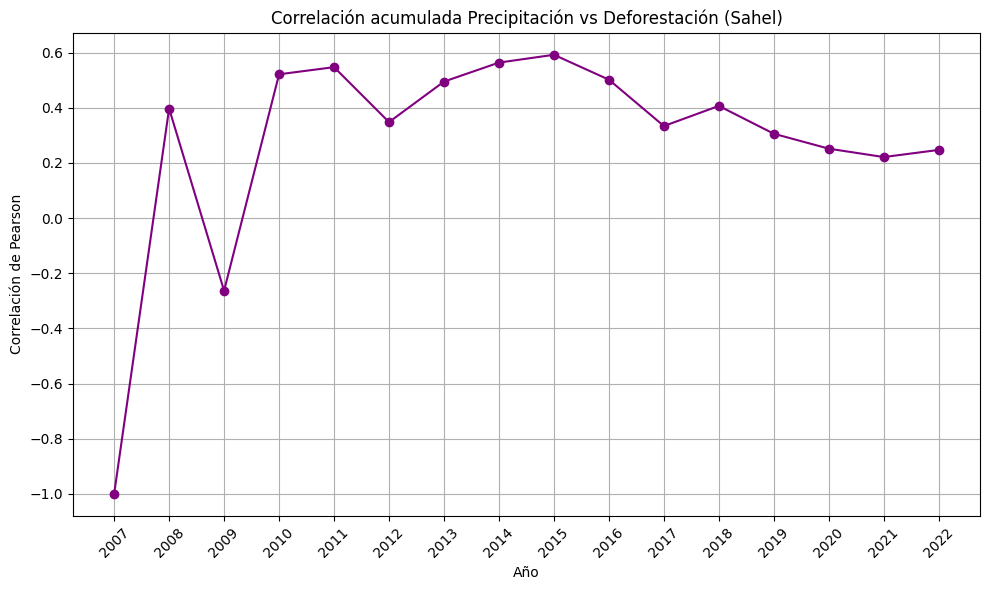

In [ ]:
import ee
import geemap
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

ee.Initialize(project='buoyant-site-454305-j8')

#Sahel
sahel_roi = ee.Geometry.BBox(-18, 5, 30, 20)

# CHIRPS por año
def get_chirps_by_year(year):
    chirps = ee.ImageCollection("UCSB-CHG/CHIRPS/PENTAD") \
        .filterDate(f"{year}-01-01", f"{year}-12-31") \
        .mean() \
        .clip(sahel_roi) \
        .reproject(crs="EPSG:4326", scale=5000)
    return chirps.updateMask(chirps.gt(0))

#MODIS por año
def get_modis_by_year(year):
    return ee.ImageCollection("MODIS/061/MCD12Q1").select("LC_Type1") \
        .filterDate(f"{year}-01-01", f"{year}-12-31") \
        .first() \
        .clip(sahel_roi) \
        .reproject(crs="EPSG:4326", scale=500)


def get_mean_values(year):
    chirps = get_chirps_by_year(year)
    modis = get_modis_by_year(year)

    precipitation_mean = chirps.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=sahel_roi,
        scale=5000,
        maxPixels=1e8
    ).get('precipitation')

    deforestation_mask = modis.eq(12)
    deforestation_mean = deforestation_mask.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=sahel_roi,
        scale=500,
        maxPixels=1e8
    ).get('LC_Type1')

    return ee.Dictionary({
        'year': year,
        'precipitation': precipitation_mean,
        'deforestation': deforestation_mean
    })
def compute_yearly_correlations():
    years = list(range(2006, 2023))
    correlations = []
    valid_years = []
    precip_list = []
    defor_list = []

    for year in years:
        try:
            mean_values = get_mean_values(year).getInfo()
            precip = mean_values['precipitation']
            defor = mean_values['deforestation']

            if precip is not None and defor is not None:
                precip_list.append(precip)
                defor_list.append(defor)

                if len(precip_list) > 1:
                    corr, _ = pearsonr(precip_list, defor_list)
                    correlations.append(corr)
                    valid_years.append(year)
        except Exception as e:
            print(f"⚠️ Error con el año {year}: {e}")

    return valid_years, correlations

# análisis
years, correlations = compute_yearly_correlations()

plt.figure(figsize=(10, 6))
plt.plot(years, correlations, marker='o', color='purple', linestyle='-')
plt.title('Correlación acumulada Precipitación vs Deforestación (Sahel)')
plt.xlabel('Año')
plt.ylabel('Correlación de Pearson')
plt.grid(True)
plt.xticks(years, rotation=45)
plt.tight_layout()
plt.show()



Mean Squared Error: 2.18
Predicción de precipitación mensual para 2025:
Mes 01: 0.31 mm
Mes 02: 0.55 mm
Mes 03: 3.90 mm
Mes 04: 4.89 mm
Mes 05: 11.02 mm
Mes 06: 17.60 mm
Mes 07: 23.84 mm
Mes 08: 28.31 mm
Mes 09: 21.18 mm
Mes 10: 11.73 mm
Mes 11: 1.91 mm
Mes 12: 0.51 mm


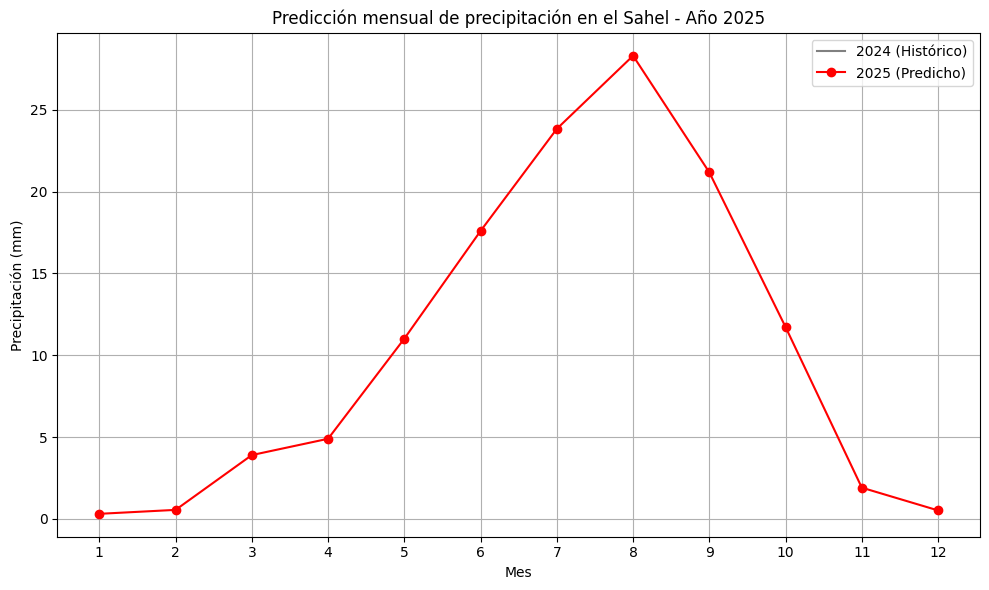

In [276]:
import ee
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

ee.Initialize(project='buoyant-site-454305-j8')

sahel_bbox = ee.Geometry.BBox(-18, 5, 30, 20)
def get_monthly_chirps(year):
    monthly_data = []
    for month in range(1, 13):
        start = f'{year}-{month:02d}-01'
        if month == 12:
            end = f'{year+1}-01-01'
        else:
            end = f'{year}-{month+1:02d}-01'

        chirps = ee.ImageCollection("UCSB-CHG/CHIRPS/PENTAD") \
            .filterDate(start, end) \
            .mean() \
            .clip(sahel_bbox) \
            .select("precipitation")

        precip = chirps.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=sahel_bbox,
            scale=5000
        ).get('precipitation').getInfo()

        monthly_data.append({
            'Year': year,
            'Month': month,
            'Precipitation': precip
        })
    return monthly_data

years = list(range(2000, 2024))
monthly_precip_data = []

for year in years:
    monthly_precip_data.extend(get_monthly_chirps(year))

df_monthly = pd.DataFrame(monthly_precip_data)

X = df_monthly[['Year', 'Month']]
y = df_monthly['Precipitation']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")

future_months = pd.DataFrame({'Year': [2025]*12, 'Month': list(range(1, 13))})
future_predictions = model.predict(future_months)

print("Predicción de precipitación mensual para 2025:")
for month, prediction in zip(range(1, 13), future_predictions):
    print(f"Mes {month:02d}: {prediction:.2f} mm")

plt.figure(figsize=(10, 6))
plt.plot(df_monthly[df_monthly['Year'] == 2024]['Month'],
         df_monthly[df_monthly['Year'] == 2024]['Precipitation'],
         label='2024 (Histórico)', color='gray')
plt.plot(range(1, 13), future_predictions, label='2025 (Predicho)', color='red', marker='o')
plt.xticks(range(1, 13))
plt.xlabel('Mes')
plt.ylabel('Precipitación (mm)')
plt.title('Predicción mensual de precipitación en el Sahel - Año 2025')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
